In [29]:
#Imports and Configuration
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install mne
!pip install tensorflow
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization, Reshape, Permute

# --- CONFIGURATION ---
SUBJECTS = list(range(1, 110))

# Runs 1 (Open Eyes) and 2 (Closed Eyes).
RUNS = [1,2]

print(f"Configuration Set: {len(SUBJECTS)} Subjects, Runs {RUNS}")

Configuration Set: 109 Subjects, Runs [1, 2]


In [34]:
# Cell 3: Define the Memory-Optimized Data Processing Function
def load_and_preprocess_data(subjects, runs):
    X_list = []
    y_list = []

    print(f"Starting Data Loading for {len(subjects)} subjects...")

    for subject_id in subjects:
        try:
            # 1. LOAD: Auto-download data from PhysioNet
            fnames = eegbci.load_data(subject_id, runs, verbose=False)
            raws = [read_raw_edf(f, preload=True, verbose=False) for f in fnames]
            raw = concatenate_raws(raws)

            # 2. FILTER: Keep only brain frequencies (1-40Hz)
            raw.pick_types(eeg=True, exclude='bads')
            raw.filter(1., 40., fir_design='firwin', skip_by_annotation='edge', verbose=False)

            # 3. EPOCH: Slice into 1-second windows
            epochs = mne.make_fixed_length_epochs(raw, duration=1.0, preload=True, verbose=False)
            data = epochs.get_data() # Shape: (Trials, Channels, TimeSamples)

            # 4. SPECTROGRAM: Convert Time-Series to Frequency-Time Image

            # STFT parameters: fs=160 (assuming 160Hz post-downsampling/default), nperseg=64 for a balance
            # This results in a time window of 64/160 = 0.4 seconds and 33 frequency bins (nfft/2 + 1)
            f, t, Zxx = stft(data, fs=160, nperseg=64)

            # Zxx shape: (Trials, Channels, FreqBins, TimeBins)
            spectrogram = np.abs(Zxx)

            # Rearrange to: (Trials, FreqBins, TimeBins, Channels) - a common ConvNet input format
            # New shape: (Trials, FreqBins, TimeBins, Channels)
            spectrogram = np.transpose(spectrogram, (0, 2, 3, 1))

            spectrogram = spectrogram.astype(np.float32)

            X_list.append(spectrogram)

            # Create labels
            y_labels = np.full(len(spectrogram), subject_id - 1)
            y_list.append(y_labels.astype(np.int32)) # Optimize labels too

        except Exception as e:
            print(f"Error loading Subject {subject_id}: {e}")

    if not X_list:
        return np.array([]), np.array([])

    X = np.concatenate(X_list)
    y = np.concatenate(y_list)

    X = X.astype(np.float32)

    return X, y

Starting Data Loading for 109 subjects...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy fun

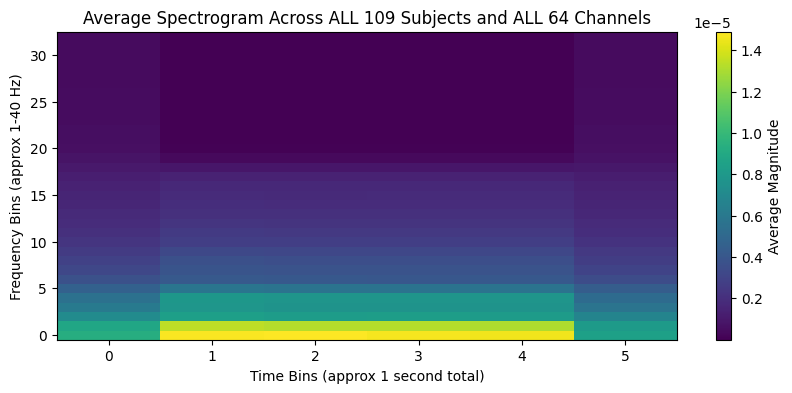

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Define a small test set for demonstration
TEST_SUBJECTS = list(range(1, 110)) # Load data for ALL 109 Subjects
TEST_RUNS = [1,2] # Open , Closed Eyes Runs

# 1. Call the function
# NOTE: Assuming 'load_and_preprocess_data' is a function defined in your notebook
# that returns the data in the shape (Trials, FreqBins, TimeBins, Channels)
X_data, y_labels = load_and_preprocess_data(TEST_SUBJECTS, TEST_RUNS)

# 2. Display the resulting shapes
print("\n✅ Data Loading Complete.")
print(f"Feature Matrix Shape (X): {X_data.shape} (Trials, FreqBins, TimeBins, Channels)")
print(f"Label Vector Shape (y): {y_labels.shape}")
print(f"Unique Labels Found: {np.unique(y_labels)}")

# 3. Visualization: Plot the spectrogram averaged across all subjects and channels
if X_data.size > 0:
    # X_data shape is (Trials, FreqBins, TimeBins, Channels)

    # CALCULATE THE AVERAGE SPECTROGRAM:
    # 1. Average across ALL Trials/Subjects (axis=0).
    # 2. Average across ALL 64 Channels (axis=3).
    # The result is the average Time-Frequency map for the entire dataset.

    # First, average over all subjects/trials (axis 0)
    avg_over_trials = X_data.mean(axis=0) # Shape: (FreqBins, TimeBins, Channels)

    # Then, average over all channels (axis 2 of the resulting array, which was axis 3)
    average_spectrogram = avg_over_trials.mean(axis=2) # Shape: (FreqBins, TimeBins)

    plt.figure(figsize=(10, 4))
    plt.imshow(average_spectrogram, aspect='auto', origin='lower', cmap='viridis')

    plt.title('Average Spectrogram Across ALL 109 Subjects and ALL 64 Channels')
    plt.xlabel('Time Bins (approx 1 second total)')
    plt.ylabel('Frequency Bins (approx 1-40 Hz)')
    plt.colorbar(label='Average Magnitude')
    plt.show()
else:
    print("Could not generate visualization: Data matrix X is empty.")

In [30]:
#Execute Loading and Normalize
X, y = load_and_preprocess_data(SUBJECTS, RUNS)

# --- NORMALIZATION ---
mean = np.mean(X)
std = np.std(X)
X_norm = (X - mean) / std

# One-hot encode labels (Required for Multi-class classification)

y_cat = tf.keras.utils.to_categorical(y, num_classes=len(SUBJECTS))

# Split into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_cat, test_size=0.2, random_state=42)

print("\n--- Data Ready ---")
print(f"Input Shape (X): {X_train.shape} -> (Samples, Time, Freq, Channels)")
print(f"Labels Shape (y): {y_train.shape}")

Starting Data Loading for 109 subjects...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy fun

Loading sample data for visualization...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 61 events and 160 original time points ...
0 bad epochs dropped


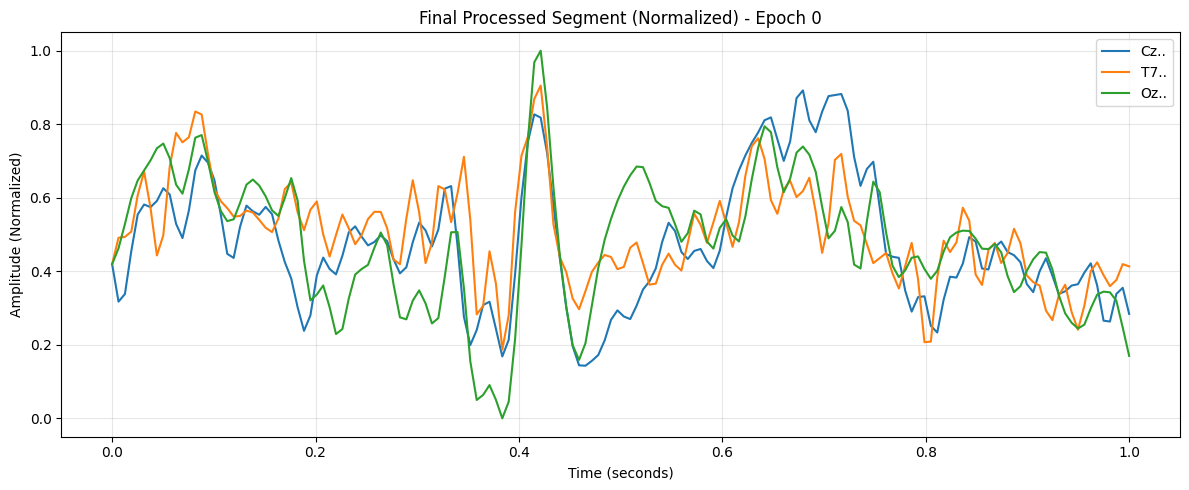

In [13]:
#Visualize the Preprocessed Time-Domain Signal

import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

# 1. Load a small sample
print("Loading sample data for visualization...")
sample_files = eegbci.load_data(1, [1], verbose=False)
raw_sample = concatenate_raws([read_raw_edf(f, preload=True, verbose=False) for f in sample_files])

# 2. Apply the same Preprocessing Steps

raw_sample.pick_types(eeg=True, exclude='bads')
raw_sample.filter(1., 40., fir_design='firwin', verbose=False)

# Segment into 1-second epochs
epochs_sample = mne.make_fixed_length_epochs(raw_sample, duration=1.0, verbose=False)
data_sample = epochs_sample.get_data() # Shape: (Epochs, Channels, Time)

# 3. Select Data to Plot

epoch_idx = 0
time_axis = np.linspace(0, 1, data_sample.shape[2]) # 0 to 1 second


ch_names = raw_sample.info['ch_names']
target_channels = ['Cz', 'T7', 'Oz'] # Common electrodes
indices = []
labels = []

for target in target_channels:

    found = [i for i, name in enumerate(ch_names) if target in name]
    if found:
        indices.append(found[0])
        labels.append(ch_names[found[0]])


if len(indices) < 3:
    indices = [10, 30, 50]
    labels = [ch_names[i] for i in indices]

# 4. Normalize for Visualization

sample_data = data_sample[epoch_idx, indices, :].T
sample_data = (sample_data - np.min(sample_data)) / (np.max(sample_data) - np.min(sample_data))

# 5. Plot
plt.figure(figsize=(12, 5))
plt.plot(time_axis, sample_data[:, 0], label=labels[0])
plt.plot(time_axis, sample_data[:, 1], label=labels[1])
plt.plot(time_axis, sample_data[:, 2], label=labels[2])

plt.title(f"Final Processed Segment (Normalized) - Epoch {epoch_idx}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (Normalized)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [14]:
#Build the Hybrid Model
def build_crnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # 1. CNN Layers (Spatial/Spectral Features)
    # Input: (Time, Freq, Channels)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)

    # 2. Prepare for RNN

    new_shape = (input_shape[0], -1) # (Time, Freq * Filters)
    x = Reshape(target_shape=new_shape)(x)

    # 3. RNN Layers (Temporal Features)
    x = LSTM(64, return_sequences=False, dropout=0.5)(x)

    # 4. Classification Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_crnn(input_shape, len(SUBJECTS))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 33, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 33, 6, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 33, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 33, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 33, 3, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 33, 3, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 33, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 109)            │         7,085 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,453 (302.55 KB)

 Trainable params: 77,261 (301.80 KB)

 Non-trainable params: 192 (768.00 B)

In [15]:
#Train the Model with Early Stopping strategy
from tensorflow.keras.callbacks import EarlyStopping

# 1. Define the Early Stopping Callback

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("Starting Training... (Max 50 epochs, but will stop early if accuracy peaks)")

# 2. Run the Training
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

print("Training Complete.")

Starting Training... (Max 50 epochs, but will stop early if accuracy peaks)
Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.0073 - loss: 4.7128 - val_accuracy: 0.0109 - val_loss: 4.6865
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.0188 - loss: 4.5615 - val_accuracy: 0.0384 - val_loss: 4.0294
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.0596 - loss: 3.7887 - val_accuracy: 0.1170 - val_loss: 3.3359
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.1167 - loss: 3.3156 - val_accuracy: 0.1745 - val_loss: 3.0221
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.1783 - loss: 2.9820 - val_accuracy: 0.2659 - val_loss: 2.6337
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.2412 - loss: 2.7190 - val_accuracy: 0.3396 - val_loss: 2.3741
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.3174 - loss: 2.4236 - val_accuracy: 0.4445 - val_loss: 2.0614
Epoch 8/50
333

--- DIAGNOSTICS ---
Length of X_test samples: 2659
Length of y_test samples: 2659
-------------------
Length of y_true_classes (True Labels): 2659
Length of y_pred_classes (Predicted Labels): 2659
Difference: 0


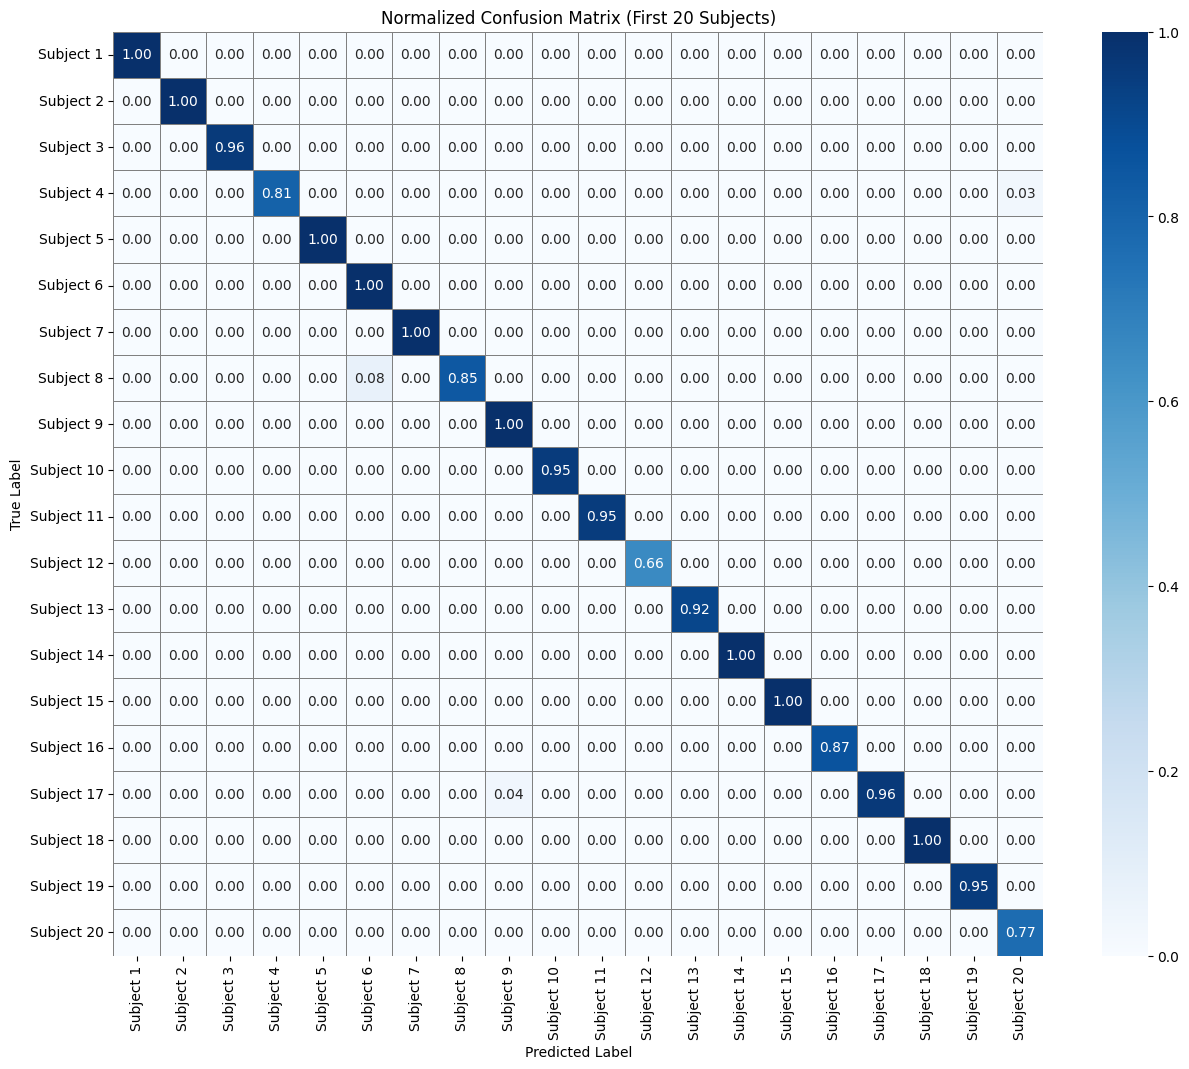


Classification Report (Overall Metrics):
              precision    recall  f1-score   support

   Subject 1     1.0000    1.0000    1.0000        32
   Subject 2     1.0000    1.0000    1.0000        20
   Subject 3     1.0000    0.9583    0.9787        24
   Subject 4     0.9615    0.8065    0.8772        31
   Subject 5     1.0000    1.0000    1.0000        21
   Subject 6     0.9091    1.0000    0.9524        20
   Subject 7     1.0000    1.0000    1.0000        27
   Subject 8     0.9565    0.8462    0.8980        26
   Subject 9     0.9286    1.0000    0.9630        26
  Subject 10     0.9545    0.9545    0.9545        22
  Subject 11     0.9500    0.9500    0.9500        20
  Subject 12     1.0000    0.6552    0.7917        29
  Subject 13     0.8462    0.9167    0.8800        24
  Subject 14     0.9688    1.0000    0.9841        31
  Subject 15     0.9565    1.0000    0.9778        22
  Subject 16     1.0000    0.8667    0.9286        15
  Subject 17     1.0000    0.9643    0.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random

# --- DIAGNOSTICS: Check Array Lengths ---
print(f"--- DIAGNOSTICS ---")
try:
    print(f"Length of X_test samples: {X_test.shape[0]}")
    print(f"Length of y_test samples: {y_test.shape[0]}")
except:
    print("X_test or y_test not found or are not NumPy arrays.")
print("-------------------")


# --- 1. Make predictions on the test set ---

# Make sure to run prediction on the correct X_test
y_pred_probs = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Correctly derive y_true_classes (Fixed Logic)
if y_test.ndim == 2:
    # If y_test is one-hot encoded (2D)
    y_true_classes = np.argmax(y_test, axis=1)
else:
    # If y_test is already class labels (1D)
    y_true_classes = y_test

# Final Check Before Matrix Calculation
print(f"Length of y_true_classes (True Labels): {len(y_true_classes)}")
print(f"Length of y_pred_classes (Predicted Labels): {len(y_pred_classes)}")
print(f"Difference: {abs(len(y_true_classes) - len(y_pred_classes))}")

if len(y_true_classes) != len(y_pred_classes):
    print("\nFATAL ERROR: Inconsistent sample lengths. Check your train_test_split and model.predict(X_test) steps.")
    # Exit early to prevent the ValueError
    raise ValueError("Inconsistent sample lengths detected.")


# --- 2. Compute the confusion matrix (Epoch-Level) ---
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Determine the number of classes dynamically
N_CLASSES = len(np.unique(y_true_classes))
TARGET_NAMES = [f'Subject {i+1}' for i in range(N_CLASSES)]


# --- 3. Plot the confusion matrix (Normalized Subset) ---

# Normalize to percentages (epoch accuracy per subject)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Select a subset to plot (e.g., the first 20 subjects for readability)
PLOT_CLASSES = 20
if N_CLASSES < PLOT_CLASSES:
    PLOT_CLASSES = N_CLASSES

plt.figure(figsize=(15, 12))
sns.heatmap(
    cm_normalized[:PLOT_CLASSES, :PLOT_CLASSES],
    annot=True,
    fmt='.2f',
    cmap='Blues',
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=TARGET_NAMES[:PLOT_CLASSES],
    yticklabels=TARGET_NAMES[:PLOT_CLASSES]
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Normalized Confusion Matrix (First {PLOT_CLASSES} Subjects)')
plt.show()

# --- 4. Display classification report for more detailed metrics ---
print("\nClassification Report (Overall Metrics):")
print(classification_report(y_true_classes, y_pred_classes, target_names=TARGET_NAMES, digits=4))